In [ ]:
import torch
from ppuu.data.dataloader import Dataset, DataStore
from torch.utils.data import DataLoader

import pytorch_lightning as pl

pl.seed_everything(1)

ds_path = "/misc/vlgscratch4/LecunGroup/nvidia-collab/traffic-data_offroad/state-action-cost/data_i80_v0/"
# ds_path = "/misc/vlgscratch4/LecunGroup/nvidia-collab/vlad/traffic-data_offroad_50_test_train_same/state-action-cost/data_i80_v0/"
data_store = DataStore(ds_path)

dataset = Dataset(
    data_store, "val", 20, 30, size=1000, normalize=True, shift=False, random_actions=False,
)
dataset.random.seed(1)

loader = DataLoader(
    dataset,
    batch_size=6,
    num_workers=0,
)

In [ ]:
itt = iter(loader)
batch = next(itt)

print(batch)

# New Forward Model

In [ ]:
from ppuu.lightning_modules import FM

# fm = FM.load_from_checkpoint('/home/us441/nvidia-collab/vlad/results/refactored_debug/test_no_shift_30_vlong_groupnorm_resume/seed=42_resume_2/checkpoints/epoch=59_success_rate=0.ckpt')
# fm = FM.load_from_checkpoint('/home/us441/nvidia-collab/vlad/results/refactored_debug/test_no_shift_20_vlong_groupnorm_beta=1e-5_continue_correct/seed=42/checkpoints/epoch=2209_success_rate=0.ckpt')
# fm = FM.load_from_checkpoint('/home/us441/nvidia-collab/vlad/results/refactored_debug/test_no_shift_20_vlong_groupnorm/seed=42/checkpoints/epoch=901_success_rate=0.ckpt')
# fm = FM.load_from_checkpoint('/home/us441/nvidia-collab/vlad/results/refactored_debug/test_no_shift_30_vlong_groupnorm/seed=42_2/checkpoints/epoch=901_success_rate=0.ckpt')
fm = FM.load_from_checkpoint('/home/us441/nvidia-collab/vlad/results/refactored_debug/reproduce_vanilla_fm_vae/seed=42_1/checkpoints/epoch=1583_success_rate=0.ckpt')
# fm.model.enable_latent = True
fm.model.z_expander.weight

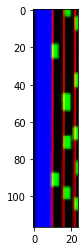

In [42]:
predictions = fm.model.unfold(batch['actions'], batch)

from matplotlib import pyplot as plt
plt.imshow(predictions['pred_images'][0][28].detach().permute(1, 2, 0).numpy())

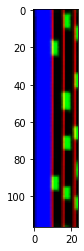

In [43]:
predictions = fm.model.unfold(batch['actions'], batch)

from matplotlib import pyplot as plt
plt.imshow(predictions['pred_images'][0][28].detach().permute(1, 2, 0).numpy())

# Old Forward Model

In [79]:
from ppuu.modeling.forward_models import ForwardModel

fm_old = ForwardModel('/misc/vlgscratch4/LecunGroup/nvidia-collab/vlad/models/offroad/model=fwd-cnn-vae-fp-layers=3-bsize=64-ncond=20-npred=20-lrt=0.0001-nfeature=256-dropout=0.1-nz=32-beta=1e-06-zdropout=0.5-gclip=5.0-warmstart=1-seed=1.step400000.model')
fm_old.cuda()

def convert_batch(batch):
    res = {}
    for k in batch:
        if k in ['input_images', 'input_states', 'actions', 'ego_cars']:
            res[k] = batch[k].cuda()
    return res
batch_c = convert_batch(batch)

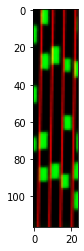

In [116]:
predictions_old = fm_old.unfold(batch_c['actions'], batch_c)

plt.imshow(predictions_old['pred_images'][0][29].detach().cpu().permute(1, 2, 0).numpy())

In [3]:
from ppuu.costs import PolicyCost

from ppuu.modeling import ForwardModel

fm = ForwardModel('/misc/vlgscratch4/LecunGroup/nvidia-collab/vlad/models/offroad/model=fwd-cnn-vae-fp-layers=3-bsize=64-ncond=20-npred=20-lrt=0.0001-nfeature=256-dropout=0.1-nz=32-beta=1e-06-zdropout=0.5-gclip=5.0-warmstart=1-seed=1.step400000.model')

fm = fm.cuda()
fm.device = torch.device('cuda:0')

cost = PolicyCost(PolicyCost.Config(), fm, data_store.stats)
cost.estimate_uncertainty_stats(loader)
# predictions = batch.copy()
# predictions['pred_images'] = batch['target_images']
# predictions['pred_states'] = batch['target_states']
# predictions['pred_actions'] = batch['actions']
# predictions['Z'] = 

[estimating normal uncertainty ranges: 100.0%]


In [5]:
for k in batch:
    if torch.is_tensor(batch[k]):
        batch[k] = batch[k].cuda()

In [5]:
from tqdm.notebook import tqdm
it = iter(loader)
x = range(0, 100, 4)
y_p = {i:[] for i in x}
y_u = {i:[] for i in x}

torch.autograd.set_grad_enabled(False)

for bi in tqdm(range(50)):
    print('processing batch', bi)
    batch = next(it)
    for k in batch:
        if torch.is_tensor(batch[k]):
            batch[k] = batch[k].cuda()

    for i in tqdm(x):
        predictions = fm.unfold(batch['actions'] * i, batch, augmenter=None)
        c = cost.calculate_cost(batch, predictions)
        y_p[i].append(c['policy_loss'].item())
        y_u[i].append(c['uncertainty_loss'].item())

processing batch 0



processing batch 1



processing batch 2



processing batch 3



processing batch 4



processing batch 5



processing batch 6



processing batch 7



processing batch 8



processing batch 9



processing batch 10



processing batch 11



processing batch 12



processing batch 13



processing batch 14



processing batch 15



processing batch 16



processing batch 17



processing batch 18



processing batch 19



processing batch 20



processing batch 21



processing batch 22



processing batch 23



processing batch 24



processing batch 25



processing batch 26



processing batch 27



processing batch 28



processing batch 29



processing batch 30



processing batch 31



processing batch 32



processing batch 33



processing batch 34



processing batch 35



processing batch 36



processing batch 37



processing batch 38



processing batch 39



processing batch 40



processing batch 41



processing batch 42



processing batch 43



processing batch 44



processing batch 45



processing batch 46



processing batch 47



processing batch 48



processing batch 49


In [12]:
from matplotlib import pyplot as plt

plt.figure(dpi=200)

import numpy as np
mean_p = [np.mean(y_p[k]) for k in x]
mean_u = [np.mean(y_u[k]) for k in x]

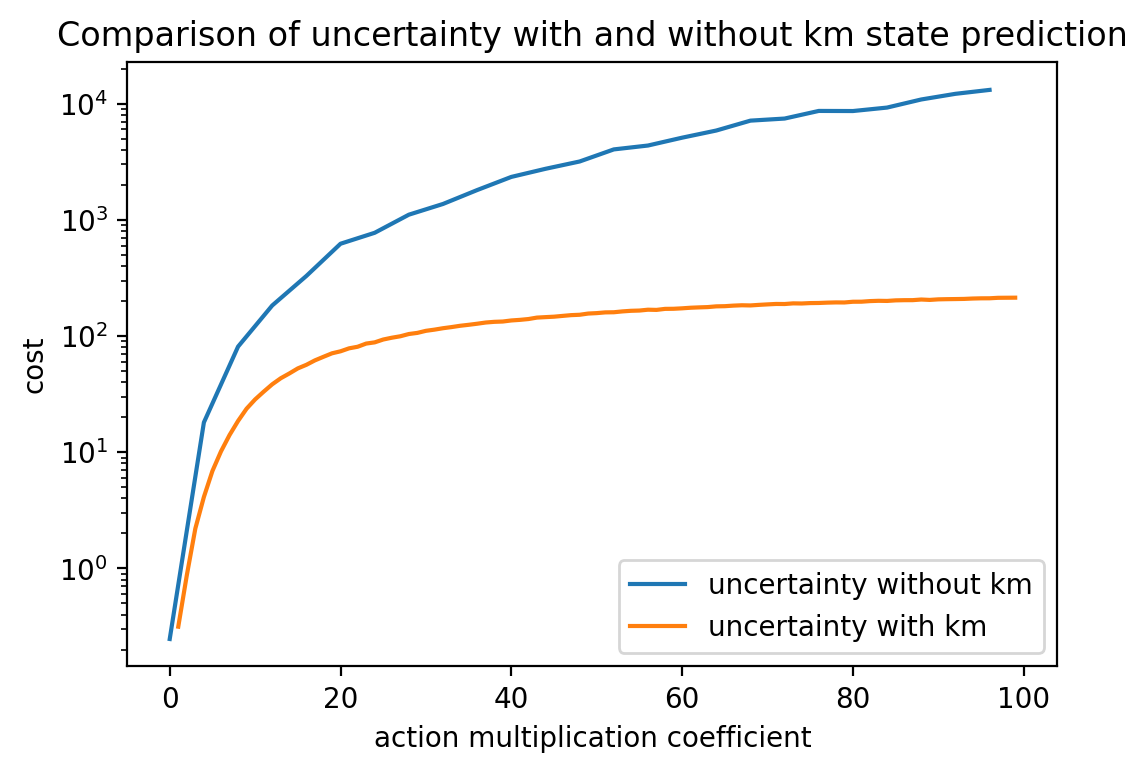

In [22]:
km_x = range(1, 100)
km_mean_p = [0.1852752535417676, 0.23218819595873355, 0.3209828170388937, 0.435350908190012, 0.5904359319806098, 0.7722653289139271, 0.9822925189137459, 1.2250089594721794, 1.4954489967226983, 1.745610262155533, 1.995418193936348, 2.2687726998329163, 2.525949056148529, 2.7475041645765303, 3.0141749250888825, 3.2134900349378586, 3.48405134499073, 3.7225751852989197, 3.9651911532878876, 4.120040116310119, 4.35591276884079, 4.485035560131073, 4.762636884450912, 4.87387644648552, 5.137632603645325, 5.319494273662567, 5.466681920289993, 5.7030235862731935, 5.829174211025238, 6.062162439823151, 6.198277747631073, 6.371425795555115, 6.506977133750915, 6.672100327014923, 6.794329123497009, 6.937133727073669, 7.096074993610382, 7.193137900829315, 7.2409054064750675, 7.387834513187409, 7.472349154949188, 7.594398543834687, 7.802717697620392, 7.875415706634522, 7.941795725822448, 8.06032729625702, 8.178433976173402, 8.239113075733185, 8.435060477256775, 8.505231311321259, 8.6256360912323, 8.651876301765443, 8.790512795448302, 8.892402956485748, 8.936862268447875, 9.08149095773697, 9.051609621047973, 9.226848640441894, 9.246889872550964, 9.328287262916565, 9.43508026599884, 9.499097228050232, 9.554871358871459, 9.687163805961609, 9.720104446411133, 9.825264048576354, 9.896388297080994, 9.866869440078736, 9.97348521232605, 10.064325799942017, 10.145460286140441, 10.136419258117677, 10.262071976661682, 10.244177632331848, 10.320735588073731, 10.344638795852662, 10.412386193275452, 10.457670488357543, 10.447334871292114, 10.59123233795166, 10.603608736991882, 10.724405899047852, 10.784566164016724, 10.763532514572143, 10.878496727943421, 10.918817200660705, 10.9222220993042, 11.0537824010849, 10.97773145198822, 11.093651294708252, 11.131303029060364, 11.1593150806427, 11.18780056476593, 11.267614760398864, 11.316126384735107, 11.324614195823669, 11.426655774116517, 11.43703848361969, 11.458305478096008]
km_mean_u = [0.31497945030219854, 0.8725676212832332, 2.205238359197974, 4.117892189323902, 6.893258612751961, 10.152441000938415, 14.039854633808137, 18.567240579128267, 23.693099019527434, 28.470583317279814, 33.18546704292297, 38.40456632137298, 43.297873668670654, 47.59346370697021, 52.651751770973206, 56.50945234298706, 61.71309357643128, 66.240500125885, 70.97630676269532, 73.87066822052002, 78.34544416427612, 80.83112457275391, 86.10351825714112, 88.19199562072754, 93.30373313903809, 96.6783532333374, 99.49767524719238, 104.03883876800538, 106.40876567840576, 110.8569552230835, 113.4743200302124, 116.71599807739258, 119.37134735107422, 122.49461101531982, 124.89053951263428, 127.58816108703613, 130.68466510772706, 132.46955211639406, 133.28304473876952, 136.13114372253418, 137.72549774169923, 140.00333278656007, 144.0729151916504, 145.42476978302003, 146.69451515197753, 148.99800621032716, 151.27196655273437, 152.36929107666015, 156.10650733947753, 157.4373913574219, 159.75129203796388, 160.16500507354738, 162.87899467468262, 164.83070121765138, 165.6739303588867, 168.47012298583985, 167.8116478729248, 171.2594457244873, 171.57927703857422, 173.12399185180664, 175.19062210083007, 176.41857856750488, 177.42978088378905, 180.03025680541992, 180.63127044677734, 182.65695762634277, 183.9603584289551, 183.33080978393554, 185.4173419189453, 187.18275451660156, 188.79739540100098, 188.54908493041992, 190.9929768371582, 190.56277099609375, 192.09948471069336, 192.49369178771974, 193.7945358276367, 194.6376416015625, 194.4276560974121, 197.23802383422853, 197.43001174926758, 199.81230056762695, 200.9726993560791, 200.45054000854492, 202.7238800048828, 203.47002334594725, 203.57749771118165, 206.15452018737793, 204.55001823425292, 206.82851264953612, 207.5664461517334, 208.0366926574707, 208.6061865234375, 210.1834275817871, 211.07351119995118, 211.24366767883302, 213.25468955993654, 213.53707946777342, 213.82301818847657]

plt.figure(dpi=200)
plt.plot(x, mean_u, label='uncertainty without km')
# plt.plot(x, mean_p, label='total cost without km')
plt.plot(km_x, km_mean_u, label='uncertainty with km')
# plt.plot(km_x, km_mean_p, label='total cost with km')
plt.yscale('log')


plt.xlabel('action multiplication coefficient')
plt.ylabel('cost')
plt.title('Comparison of uncertainty with and without km state prediction')
plt.legend()
plt.show()

In [2]:
import torch
x = torch.rand(100, 20)

In [3]:
x.shape
indices = torch.tensor([2] * 100)
i = torch.arange(0, 100)
k = torch.stack((i, indices), dim=1)

In [4]:
k

tensor([[ 0,  2],
        [ 1,  2],
        [ 2,  2],
        [ 3,  2],
        [ 4,  2],
        [ 5,  2],
        [ 6,  2],
        [ 7,  2],
        [ 8,  2],
        [ 9,  2],
        [10,  2],
        [11,  2],
        [12,  2],
        [13,  2],
        [14,  2],
        [15,  2],
        [16,  2],
        [17,  2],
        [18,  2],
        [19,  2],
        [20,  2],
        [21,  2],
        [22,  2],
        [23,  2],
        [24,  2],
        [25,  2],
        [26,  2],
        [27,  2],
        [28,  2],
        [29,  2],
        [30,  2],
        [31,  2],
        [32,  2],
        [33,  2],
        [34,  2],
        [35,  2],
        [36,  2],
        [37,  2],
        [38,  2],
        [39,  2],
        [40,  2],
        [41,  2],
        [42,  2],
        [43,  2],
        [44,  2],
        [45,  2],
        [46,  2],
        [47,  2],
        [48,  2],
        [49,  2],
        [50,  2],
        [51,  2],
        [52,  2],
        [53,  2],
        [54,  2],
        [5

In [5]:
x[[(98, 2)]].shape

torch.Size([2, 20])

In [20]:
t = torch.rand(2, 3, 3)
ind = torch.zeros(1, 3, 3)
r = torch.gather(t, 0, ind)

In [21]:
r

tensor([[[0.8231, 0.9281, 0.9181],
         [0.6667, 0.4900, 0.4124],
         [0.0848, 0.4880, 0.0849]]])